In [8]:
import pandas as pd
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()




In [1]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def macd_diff(df,i):
    return df.loc[i,'macd']-df.loc[i,'signal']
    
def get_almost_macd_signal(df,hold,i):
    if (i<2):
        return False
    if (hold):
        if (macd_diff(df,i)<macd_diff(df,i-1) and macd_diff(df,i-1)<macd_diff(df,i-2) and macd_diff(df,i)>0 and macd_diff(df,i)<1):
            return True
        return False
    else:
        if (macd_diff(df,i)>macd_diff(df,i-1) and macd_diff(df,i-1)>macd_diff(df,i-2) and macd_diff(df,i)<0 and macd_diff(df,i)>-1):
            return True
        return False

def get_almost_macd_signal1(df,hold,i):
    if (i<2):
        return False
    if (hold):
        if (macd_diff(df,i)<macd_diff(df,i-1) and macd_diff(df,i-1)<macd_diff(df,i-2) and macd_diff(df,i)>0 and macd_diff(df,i)<0.1):
            return True
        return False
    else:
        if (macd_diff(df,i)>macd_diff(df,i-1) and macd_diff(df,i-1)>macd_diff(df,i-2) and macd_diff(df,i)<0 and macd_diff(df,i)>-0.1):
            return True
        return False
    
def get_almost_macd_signal2(df,hold,i):
    if (i<2):
        return False
    if (hold):
        if (macd_diff(df,i)<macd_diff(df,i-1) and macd_diff(df,i-1)<macd_diff(df,i-2) and macd_diff(df,i)>0 and macd_diff(df,i)<0.01):
            return True
        return False
    else:
        if (macd_diff(df,i)>macd_diff(df,i-1) and macd_diff(df,i-1)>macd_diff(df,i-2) and macd_diff(df,i)<0 and macd_diff(df,i)>-0.01):
            return True
        return False
    
    
    
    
def get_macd_signal(df,hold,i):
    if (hold):
        if ((df.iloc[i])['macd']<(df.iloc[i])['signal']):
            return True
        return False
    else:
        if ((df.iloc[i])['macd']>(df.iloc[i])['signal']):
            return True
        return False

def get_macd_signal_new(df,hold,i):
    if (i<1):
        return False
    
    if (hold):
        if (((df.iloc[i-1])['macd']>(df.iloc[i-1])['signal']) and ((df.iloc[i])['macd']<(df.iloc[i])['signal'])):
            return True
        return False
    else:
        if (((df.iloc[i-1])['macd']<(df.iloc[i-1])['signal']) and ((df.iloc[i])['macd']>(df.iloc[i])['signal'])):
            return True
        return False    
     
def naive_backtest(df,get_signal):
    pv=1000
    hold=False
    start_price=-float("inf")
    
    total_trade=0
    win_count=0
    
    #count=0
    for i in range(len(df)):
        if (hold):
            if (get_signal(df,hold,i)):
                end_price=df.iloc[i]['Adj Close']
                pv*=end_price/start_price
                hold=False
                
                total_trade+=1
                if (end_price>start_price):
                    win_count+=1
        else:
            if (get_signal(df,hold,i)):
                #count+=1
                start_price=df.iloc[i]['Adj Close']
                hold=True
    #print(count) 
    return (pv,total_trade,win_count)


def backtest_one_day(df,get_signal):
    pv=1000

    total_trade=0
    win_count=0
    
    #count=0
    for i in range(len(df)-1):
        if (get_signal(df,False,i)):
            #count+=1
            start_price=df.iloc[i]['Adj Close']
            end_price=df.iloc[i+1]['Adj Close']
            pv*=end_price/start_price

            total_trade+=1
            if (end_price>start_price):
                win_count+=1
            #print(pv,start_price,end_price)
    #print(count)
    return (pv,total_trade,win_count)

def backtest_one_day_short_possible(df,get_signal):
    pv=1000

    total_trade=0
    win_count=0
    
    for i in range(len(df)-1):
        if (get_signal(df,False,i)):
            start_price=df.iloc[i]['Adj Close']
            end_price=df.iloc[i+1]['Adj Close']
            pv*=end_price/start_price
            
            total_trade+=1
            if (end_price>start_price):
                win_count+=1
        elif (get_signal(df,True,i)):
            start_price=df.iloc[i]['Adj Close']
            end_price=df.iloc[i+1]['Adj Close']
            pv*=start_price/end_price
            
            total_trade+=1
            if (end_price<start_price):
                win_count+=1
        
    return (pv,total_trade,win_count)

China_A_list=['601318.ss','603938.ss','002229.sz','603722.ss','600519.ss','300065.sz','000002.sz','000010.sz','000035.sz','301487.sz','300570.sz'\
         '688359.ss','301203.sz','000564.sz','002362.sz','688333.ss','002230.sz','002415.sz','002262.sz','001979.sz','601099.ss']
#200 stocks randomly sampled from all stocks in NASDAQ
#in the time range 2010-01-01 to 2023-08-01, only 183 stocks are available
nasdaq_100=['FI','AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'ASML', 'AVGO', 'PEP', 'COST', 'AZN', 'CSCO', 'TMUS', 'ADBE', 'TXN', 'AMD', 'CMCSA', 'NFLX', 'QCOM', 'HON', 'AMGN', 'INTU', 'INTC', 'SBUX', 'AMAT', 'GILD', 'PDD', 'ADI', 'BKNG', 'MDLZ', 'ADP', 'REGN', 'ISRG', 'PYPL', 'VRTX', 'ABNB', 'LRCX', 'MU', 'ATVI', 'MELI', 'PANW', 'CSX', 'CHTR', 'SNPS', 'MRNA', 'CDNS', 'JD', 'KLAC', 'MNST', 'FTNT', 'ORLY', 'MAR', 'KDP', 'NXPI', 'KHC', 'MCHP', 'DXCM', 'CTAS', 'AEP', 'ADSK', 'IDXX', 'EXC', 'PAYX', 'BIIB', 'WDAY', 'LULU', 'SGEN', 'PCAR', 'ODFL', 'MRVL', 'WBD', 'ROST', 'XEL', 'ILMN', 'CPRT', 'EA', 'CRWD', 'DLTR', 'CTSH', 'FAST', 'VRSK', 'ENPH', 'WBA', 'ANSS', 'BKR', 'CSGP', 'CEG', 'ALGN', 'FANG', 'TEAM', 'EBAY', 'DDOG', 'ZM', 'ZS', 'LCID', 'SIRI', 'RIVN']
nasdaq_random=['BOXL', 'PBLA', 'NMIH', 'OCCI', 'ONYXU', 'BRFH', 'ATRC', 'VISL', 'AMBA', 'ANDE', 'BIOL', 'MASI', 'FNCB', 'GDYN', 'RDUS', 'SGMA', 'BIAF', 'OSUR', 'DCPH', 'CPRT', 'AFBI', 'BLACU', 'AKU', 'TBMC', 'ME', 'CLPT', 'HURC', 'CHKEW', 'COOLW', 'GENK', 'BTBT', 'GLUE', 'CNOBP', 'APGE', 'UCTT', 'VERU', 'CSWCZ', 'PEGY', 'HTZ', 'IRTC', 'BMBL', 'PLXS', 'LINK', 'ZEUS', 'HOWL', 'CVKD', 'UG', 'XRX', 'ELVN', 'IOVA', 'INBX', 'VIAV', 'BBIO', 'LUXH', 'FRBA', 'COHU', 'PUBM', 'INDB', 'AMAT', 'FEIM', 'ATER', 'ADBE', 'FINW', 'BYRN', 'AVT', 'MDWT', 'SVC', 'IDN', 'ERII', 'DMRC', 'CGEM', 'CPHC', 'OCUP', 'SURF', 'VTNR', 'TFSL', 'BSET', 'IVCP', 'WAVD', 'VMD', 'EAR', 'TILE', 'GLLI', 'VTRS', 'GNLN', 'HGBL', 'MCAF', 'SONN', 'CAPR', 'PGC', 'XOMAO', 'VALU', 'ACVA', 'LIVE', 'GOGO', 'EFSC', 'APDN', 'MXL', 'IDCC', 'WINT', 'WERN', 'DKNG', 'AMPGW', 'LQDT', 'BCAB', 'CNFR', 'ALKT', 'POWL', 'SRDX', 'DUOT', 'HFWA', 'MPRA', 'CZFS', 'CDXS', 'CGBD', 'GLSI', 'OXSQ', 'CRVS', 'MSSAU', 'BTCY', 'LFMD', 'MTEX', 'TECTP', 'PAYS', 'KOD', 'PROV', 'BSFC', 'PFTA', 'JNVR', 'ZI', 'FMAO', 'CARA', 'VRA', 'RILYK', 'INBK', 'ENG', 'TRINL', 'PRSR', 'THRM', 'PTPI', 'IMMX', 'ISPO', 'BVS', 'ARCC', 'APPN', 'BLKB', 'OXSQG', 'PATK', 'KZR', 'GH', 'GIA', 'ADEA', 'ICUI', 'BDTX', 'ISPR', 'ADMA', 'INBKZ', 'UONEK', 'UTRS', 'ACAX']
hk_stocks_random=['0237.HK', '1771.HK', '1118.HK', '0570.HK', '3396.HK', '1515.HK', '2314.HK', '1069.HK', '1966.HK', '1013.HK', '0330.HK', '2948.HK', '8066.HK', '0046.HK', '0605.HK', '1766.HK', '0372.HK', '1300.HK', '1115.HK', '3363.HK', '2011.HK', '0242.HK', '0648.HK', '1808.HK', '1139.HK', '1383.HK', '0160.HK', '0820.HK', '8028.HK', '0366.HK', '0731.HK', '0802.HK', '1396.HK', '0604.HK', '1266.HK', '1189.HK', '0224.HK', '8193.HK', '0184.HK', '0585.HK', '0431.HK', '0883.HK', '0254.HK', '0455.HK', '1057.HK', '0156.HK', '0093.HK', '2607.HK', '3027.HK', '8162.HK', '0343.HK', '2009.HK', '0480.HK', '0730.HK', '0868.HK', '0687.HK', '6288.HK', '2362.HK', '0295.HK', '0023.HK', '0840.HK', '0590.HK', '0660.HK', '3300.HK', '1025.HK', '0506.HK', '0906.HK', '0075.HK', '0343.HK', '1004.HK', '8137.HK', '0272.HK', '1808.HK', '3331.HK', '2607.HK', '1000.HK', '2193.HK', '2623.HK', '1280.HK', '0613.HK', '0844.HK', '8379.HK', '1105.HK', '3839.HK', '1681.HK', '1271.HK', '0168.HK', '0256.HK', '0130.HK', '6830.HK', '8237.HK', '0041.HK', '0131.HK', '0859.HK', '2212.HK', '0475.HK', '0722.HK', '0713.HK', '0483.HK', '1360.HK', '1999.HK', '2298.HK', '8005.HK', '0853.HK', '3100.HK', '1113.HK', '0995.HK', '8036.HK', '2196.HK', '0589.HK', '0820.HK', '3091.HK', '0567.HK', '3136.HK', '8219.HK', '0988.HK', '6896.HK', '8305.HK', '0423.HK', '8041.HK', '0351.HK', '3608.HK', '1168.HK', '0116.HK', '0268.HK', '0367.HK', '1002.HK', '1087.HK', '1400.HK', '1138.HK', '0863.HK', '0005.HK', '0809.HK', '2211.HK', '1689.HK', '0229.HK', '0853.HK', '3398.HK', '8172.HK', '6133.HK', '3816.HK', '0399.HK', '3055.HK', '0493.HK', '0132.HK']
China_A_random=['600582.SS', '600419.SS', '600505.SS', '900937.SS', '600500.SS', '600982.SS', '600075.SS', '600513.SS', '600804.SS', '600201.SS', '600444.SS', '600423.SS', '600128.SS', '600326.SS', '600143.SS', '600059.SS', '601777.SS', '600795.SS', '600588.SS', '600571.SS', '600243.SS', '601555.SS', '603669.SS', '603969.SS', '600478.SS', '512600.SS', '600771.SS', '600058.SS', '600697.SS', '600745.SS', '600721.SS', '600860.SS', '600036.SS', '512510.SS', '600125.SS', '600867.SS', '600113.SS', '600490.SS', '510900.SS', '600645.SS', '600539.SS', '600316.SS', '600763.SS', '600127.SS', '600988.SS', '600076.SS', '600858.SS', '600106.SS', '600622.SS', '601519.SS', '600628.SS', '600337.SS', '600507.SS', '600715.SS', '600468.SS', '600269.SS', '601126.SS', '600096.SS', '600604.SS', '600396.SS', '600273.SS', '600297.SS', '900940.SS', '600241.SS', '600655.SS', '600331.SS', '600550.SS', '600358.SS', '600331.SS', '600671.SS', '603789.SS', '600179.SS', '601288.SS', '600761.SS', '600729.SS', '600549.SS', '600337.SS', '600227.SS', '603678.SS', '600006.SS', '600067.SS', '603600.SS', '600661.SS', '600735.SS', '600281.SS', '603026.SS', '601628.SS', '600971.SS', '600105.SS', '600523.SS', '600750.SS', '900926.SS', '600408.SS', '600658.SS', '603012.SS', '600136.SS', '600643.SS', '510030.SS', '513030.SS', '512330.SS', '600725.SS', '600718.SS', '600730.SS', '600118.SS', '600521.SS', '600433.SS', '600370.SS', '600601.SS', '601288.SS', '512990.SS', '600869.SS', '600967.SS', '600110.SS', '600967.SS', '600115.SS', '603018.SS', '512070.SS', '600545.SS', '600738.SS', '600855.SS', '600267.SS', '600418.SS', '600107.SS', '601799.SS', '600727.SS', '600727.SS', '600499.SS', '601998.SS', '600606.SS', '600118.SS', '600119.SS', '600098.SS', '600696.SS', '601988.SS', '600460.SS', '600420.SS', '600758.SS', '600822.SS', '601766.SS', '603669.SS', '600167.SS', '600325.SS', '603918.SS', '511010.SS', '518880.SS', '603899.SS', '601677.SS', '600262.SS', '600894.SS', '603519.SS', '510880.SS', '601288.SS', '600096.SS', '600707.SS', '600085.SS']

In [32]:
df=pd.read_excel(r"C:\Users\Administrator\Desktop\ARIN7600\experiment_result\Yahoo Ticker Symbols - September 2017.xlsx")


In [36]:
China_A=df[df['Unnamed: 4']=='China']['Yahoo Stock Tickers'].to_list()

In [37]:
China_A_random=random.choices(China_A,k=180)

In [12]:
hk_stocks=hk_stocks.to_list()
import random
hk_stocks_random=random.choices(hk_stocks,k=180)

<Axes: xlabel='Date'>

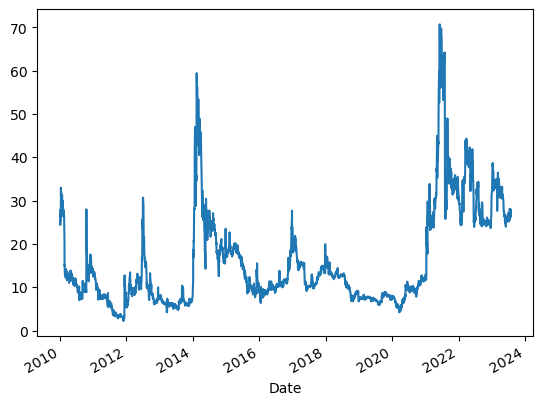

In [8]:
df=data.get_data_yahoo(tickers='LIVE',start='2010-01-01',end='2023-08-01',progress=False)
df['Adj Close'].plot()

<Axes: xlabel='Date'>

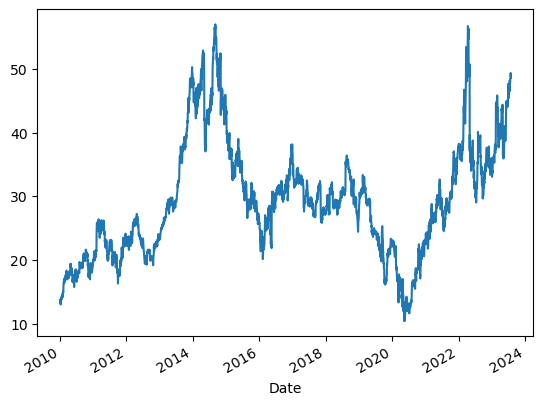

In [6]:
df=data.get_data_yahoo(tickers='ANDE',start='2010-01-01',end='2023-08-01',progress=False)
df['Adj Close'].plot()

In [16]:
#buy and hold
temp=[]

import time

counts={}

#start=time.time()

temp=[]
for t in nasdaq_random:
    df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01',progress=False)
    df_macd = get_macd(df['Close'], 26, 12, 9)
    df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    temp.append(1000*df_enlarged.iloc[-1]['Adj Close']/df_enlarged.iloc[0]['Adj Close'])
    #temp.append(len(df_enlarged))
#end=time.time()    
#print(end-start)
    
import numpy as np
temp=np.reshape(np.array(temp),(-1,1))
res=[]
for _ in range(len(temp)):
    tmp=[0]*len(temp[0])
    res.append(tmp)
df_plot=pd.DataFrame(res)

for i in range(len(temp)):
    for j in range(len(temp[0])):
        df_plot.loc[i,j]=temp[i][j]
        
df_plot.to_excel("buy_hold.xlsx")

126.20999908447266

In [93]:
#almost MACD: how often does it get an MACD golden crossover?
temp=[]

import time

counts={}

#start=time.time()

for span in range(3,10):
    total_count=0
    MACD_count=0
    for t in nasdaq_random:
        df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01',progress=False)
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
        for i in range(2,len(df_enlarged)-1):
            if (macd_diff(df_enlarged,i)>macd_diff(df_enlarged,i-1) and \
                macd_diff(df_enlarged,i-1)>macd_diff(df_enlarged,i-2) and macd_diff(df_enlarged,i)<0 \
                and macd_diff(df_enlarged,i)>-0.01):
                total_count+=1
                if (macd_diff(df_enlarged,i+1)>0 and macd_diff(df_enlarged,i)<0):
                    MACD_count+=1
                
    counts[span]=(MACD_count,total_count)

#end=time.time()    
#print(end-start)
    
temp=[]
for span in range(3,10):
    temp.append(list(counts[span]))

res=[]
for _ in range(len(temp)):
    tmp=[0]*len(temp[0])
    res.append(tmp)
df_plot=pd.DataFrame(res)

for i in range(len(temp)):
    for j in range(len(temp[0])):
        df_plot.loc[i,j]=temp[i][j]
        
df_plot.to_excel("almost_MACD_find_MACD.xlsx")

In [ ]:
#find how many times there will be earning when an MACD golden crossover appears.
temp=[]

import time

counts={}

#start=time.time()
res={}
long_c={}
total_c={}
for span in range(3,10):
    total_count=0
    long_count=0
    
    
    res[span]=[]
    long_c[span]={}
    total_c[span]={}
    
    maxres=-float("inf")
    minres=float("inf")
    for t in ['CSWCZ']:
        
        long_c[span][t]=0
        total_c[span][t]=0
        
        total_profit=1
        df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01',progress=False)
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
        for i in range(1,len(df_enlarged)):
            if (macd_diff(df_enlarged,i)>0 and macd_diff(df_enlarged,i-1)<0):
                total_c[span][t]+=1
                total_count+=1
                if (df_enlarged.loc[i,'Adj Close']>df_enlarged.loc[i-1,'Adj Close']):
                    long_c[span][t]+=1
                    long_count+=1
                total_profit*=(df_enlarged.loc[i,'Adj Close']/df_enlarged.loc[i-1,'Adj Close'])
                #print(span,total_profit,df_enlarged.loc[i,'Adj Close']/df_enlarged.loc[i-1,'Adj Close'],total_count)
             
                #total_profit+=(df_enlarged.loc[i,'Close']-df_enlarged.loc[i-1,'Close'])
                #print(df_enlarged.loc[i,'Close']-df_enlarged.loc[i-1,'Close'])
        minres=min(total_profit,minres)
        maxres=max(total_profit,maxres)
        res[span].append(total_profit)
        
    counts[span]=(long_count,total_count,minres,maxres)

#end=time.time()    
#print(end-start)
    
temp=[]
for span in range(3,10):
    temp.append(list(counts[span]))

rs=[]
for _ in range(len(temp)):
    tmp=[0]*len(temp[0])
    rs.append(tmp)
df_plot=pd.DataFrame(rs)

for i in range(len(temp)):
    for j in range(len(temp[0])):
        df_plot.loc[i,j]=temp[i][j]
        
#df_plot.to_excel("long_on_the_day_of_crossover.xlsx")

#import pandas as pd
#pd.DataFrame.from_dict(res, orient='index',columns=nasdaq_random).to_excel("sell_on_MACD_crossover_nasdaq_random.xlsx")

In [ ]:
#对应“MACD金死叉对单调2”表格
temp=[]
for t in ['601318.ss','603938.ss','002229.sz','603722.ss','600519.ss','300065.sz','000002.sz','000010.sz','000035.sz','301487.sz','300570.sz'\
         '688359.ss','301203.sz','000564.sz','002362.sz','688333.ss','002230.sz','002415.sz','002262.sz','001979.sz','601099.ss']:
    df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01')
    df_macd = get_macd(df['Close'], 26, 12, 9)
    df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    
    temp.append([])
    a=naive_backtest(df_enlarged,get_macd_signal)
    print(a,end="")
    temp[-1].extend(a)
    
    a=naive_backtest(df_enlarged,get_almost_macd_signal)
    print(a)
    temp[-1].extend(a)

In [95]:
df_plot.to_excel(f"MACD_and_almost_MACD{span}.xlsx")

In [103]:
#check how the strategy of buying on the day of MACD golden crossover and buying when almost_MACD is detected
#behave w.r.t. each other

for span in range(3,10):
    temp=[]
    for t in nasdaq_random:
        #start=time.time()
        
        df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01',progress=False)
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()

        temp.append([])
        a=backtest_one_day(df_enlarged,get_macd_signal_new)
        #print(a,end="")
        temp[-1].extend(a)

        a=backtest_one_day(df_enlarged,get_almost_macd_signal)
        #print(a)
        temp[-1].extend(a)
 
        #end=time.time()
    
        
    
    res=[]
    for _ in range(len(temp)):
        tmp=[0]*len(temp[0])
        res.append(tmp)
    df_plot=pd.DataFrame(res)

    for i in range(len(temp)):
        for j in range(len(temp[0])):
            df_plot.loc[i,j]=temp[i][j]

    df_plot.to_excel(f"MACD_and_almost_MACD{span}.xlsx")
 

#print(end-start)

In [15]:

for span in range(3,10):
    temp=[]
    for t in nasdaq_random:
        #start=time.time()
        
        df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01',progress=False)
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
 
        temp.append([])
        a=backtest_one_day(df_enlarged,get_almost_macd_signal1)
        #print(a,end="")
        temp[-1].extend(a)

        a=backtest_one_day(df_enlarged,get_almost_macd_signal2)
        #print(a)
        temp[-1].extend(a)
 
        #end=time.time()
    res=[]
    for _ in range(len(temp)):
        tmp=[0]*len(temp[0])
        res.append(tmp)
    df_plot=pd.DataFrame(res)

    for i in range(len(temp)):
        for j in range(len(temp[0])):
            df_plot.loc[i,j]=temp[i][j]

    df_plot.to_excel(f"MACD_and_almost_MACD{span}.xlsx")
 
        
    


In [ ]:
temp=[]
for t in ['601318.ss','603938.ss','002229.sz','603722.ss','600519.ss','300065.sz','000002.sz','000010.sz','000035.sz',\
         '688359.ss','301203.sz','000564.sz','002362.sz','688333.ss','002230.sz','002415.sz','002262.sz','001979.sz','601099.ss']:
    df=data.get_data_yahoo(tickers=t,start='2010-01-01',end='2023-08-01')
    df_macd = get_macd(df['Close'], 26, 12, 9)
    df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    
    temp.append([])
    #a=backtest_one_day_short_possible(df_enlarged,get_macd_signal_new)
    #print(a,end="")
    #temp[-1].extend(a)
    
    a=backtest_one_day_short_possible(df_enlarged,get_almost_macd_signal)
    print(a)
    temp[-1].extend(a)

In [ ]:
temp=[]
for span in range(3,10):
    temp.append(list(counts[span]))

res=[]
for _ in range(len(temp)):
    tmp=[0]*len(temp[0])
    res.append(tmp)
df_plot=pd.DataFrame(res)

for i in range(len(temp)):
    for j in range(len(temp[0])):
        df_plot.loc[i,j]=temp[i][j]
        
df_plot.to_excel("long_on_the_day_of_crossover.xlsx")

In [53]:
res.shape

(160, 29)

In [44]:
len(almost_win)

91

In [43]:
almost_win=[]
def almost_win_it(i,k,j):
    return ((res[i][4*k+j]>res[i][0]) and (res[i][4*k+j]>res[i][4*k+4]) and (res[i][4*k+j]>1000))
    
for i in range(len(res)):
    for k in range(7):
        if (almost_win_it(i,k,1) or almost_win_it(i,k,2) or almost_win_it(i,k,3)):
            almost_win.append(i)
            break

In [42]:
#现在检验nasdaq_random上
#先算buy and hold
temp=[]
temp1=[]
for t in nasdaq_random:
    df=data.get_data_yahoo(tickers=t,start='2021-08-01',end='2023-08-01',progress=False)
    temp.append(1000*df.iloc[-1]['Adj Close']/df.iloc[0]['Adj Close'])

    temp1.append([])
    for span in range(3,10):
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    

        a=[backtest_one_day(df_enlarged,get_almost_macd_signal2)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal1)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_macd_signal_new)[0]]
        temp1[-1].extend(a)
    
    
import numpy as np
temp=np.reshape(np.array(temp),(-1,1))
buy_and_hold=temp
MACDs=np.array(temp1)
res=np.concatenate((buy_and_hold,MACDs),axis=1)

In [25]:
temp=[]
temp1=[]
for t in hk_stocks_random:
    df=data.get_data_yahoo(tickers=t,start='2021-08-01',end='2023-08-01',progress=False)
    temp.append(1000*df.iloc[-1]['Adj Close']/df.iloc[0]['Adj Close'])

    temp1.append([])
    for span in range(3,10):
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    

        a=[backtest_one_day(df_enlarged,get_almost_macd_signal2)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal1)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_macd_signal_new)[0]]
        temp1[-1].extend(a)
    
    
import numpy as np
temp=np.reshape(np.array(temp),(-1,1))
buy_and_hold=temp
MACDs=np.array(temp1)
res=np.concatenate((buy_and_hold,MACDs),axis=1)

In [17]:
nasdaq_random.index("BTCY")

119

In [14]:
temp=[]
temp1=[]
for t in ['PTPI','DKNG','BTCY']:
    df=data.get_data_yahoo(tickers=t,start='2018-08-01',end='2021-07-31',progress=False)
    temp.append(1000*df.iloc[-1]['Adj Close']/df.iloc[0]['Adj Close'])

    temp1.append([])
    for span in range(3,10):
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    

        a=[backtest_one_day(df_enlarged,get_almost_macd_signal2)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal1)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_macd_signal_new)[0]]
        temp1[-1].extend(a)
    
    
import numpy as np
temp=np.reshape(np.array(temp),(-1,1))
buy_and_hold=temp
MACDs=np.array(temp1)
res=np.concatenate((buy_and_hold,MACDs),axis=1)

In [41]:
temp=[]
temp1=[]
for t in China_A_random:
    df=data.get_data_yahoo(tickers=t,start='2021-08-01',end='2023-08-01',progress=False)
    temp.append(1000*df.iloc[-1]['Adj Close']/df.iloc[0]['Adj Close'])

    temp1.append([])
    for span in range(3,10):
        df_macd = get_macd(df['Close'], 26, 12, span)
        df_enlarged=pd.concat([df,df_macd],axis=1)[1:].reset_index()
    

        a=[backtest_one_day(df_enlarged,get_almost_macd_signal2)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal1)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_almost_macd_signal)[0]]
        temp1[-1].extend(a)
        a=[backtest_one_day(df_enlarged,get_macd_signal_new)[0]]
        temp1[-1].extend(a)
    
    
import numpy as np
temp=np.reshape(np.array(temp),(-1,1))
buy_and_hold=temp
MACDs=np.array(temp1)
res=np.concatenate((buy_and_hold,MACDs),axis=1)

In [15]:
temp=res#np.concatenate((buy_and_hold,almost_MACD,MACD_crossover),axis=1)
rs=[]
for _ in range(len(temp)):
    tmp=[0]*len(temp[0])
    rs.append(tmp)
df_plot=pd.DataFrame(rs)

for i in range(len(temp)):
    for j in range(len(temp[0])):
        df_plot.loc[i,j]=temp[i][j]
        
df_plot.to_excel("MACD2yearsSMALLRANDOM.xlsx")


In [30]:
count=0
for i in range(len(buy_and_hold)):
    if ((almost_MACD[i][0]>buy_and_hold[i][0]) and (almost_MACD[i][0]>MACD_crossover[i][0]) and almost_MACD[i][0]>1000):
        count+=1

In [31]:
hk_stocks_random[139]

'6133.HK'

In [38]:
buy_and_hold,almost_MACD,MACD_crossover

(array([[166.11300689],
        [133.22259728]]),
 array([[ 787.27171598],
        [5337.8086191 ]]),
 array([[895.99371977],
        [474.01001391]]))

In [40]:
nasdaq_random[101]

'DKNG'

In [41]:
np.reshape(np.array([[3,4],[5,6]]),(-1,2))

array([[3, 4],
       [5, 6]])